Library Import

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import SPSA
import pandas as pd
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")
from pylab import cm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, BasicAer, IBMQ, execute, Aer, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer

# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import cm
from sklearn import metrics

# QKT related
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
# from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.algorithms.state_fidelities import ComputeUncompute
# from qiskit.primitives import Sampler

# Additional imports
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from collections import Counter

In [3]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Preparing the Dataset

In [4]:
df = pd.read_csv(r'STANDARDIZED SAMPLE.csv')
ytrain= df.iloc[:,7]
Xtrain= df.iloc[:,1:7]
Xtrain

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
0,-0.108643,-0.458618,-1.122023,-0.945244,2.504221,-1.053616
1,-0.270546,-0.467818,0.572158,0.821692,-0.386126,-0.342973
2,0.434519,0.943128,-0.368585,-0.357813,-0.804757,-0.731751
3,0.358127,-0.676976,0.087629,-9.286989,0.962594,1.208524
4,0.710329,-1.689018,-0.300498,0.580295,0.220930,0.659805
...,...,...,...,...,...,...
1195,0.002870,0.031966,0.555103,0.660490,1.108182,-0.584349
1196,0.898031,-1.843809,0.283783,0.509437,0.565864,0.733411
1197,0.308100,-0.268417,1.335523,0.440793,0.019946,-0.341390
1198,-0.430117,2.765807,-0.621706,0.292100,-0.100907,-0.596006


In [5]:
#To reduce training dataset size
Xtrain,Xtest , ytrain, ytest = train_test_split(Xtrain, ytrain,stratify=ytrain, test_size=0.98)

In [6]:
Xtrain

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
353,-2.035985,0.132127,-1.606552,0.304405,2.353069,0.388405
812,1.458003,-0.013155,-1.951359,0.445411,-3.933072,1.112576
601,0.509371,0.204346,0.059725,0.627529,-0.695400,-0.000935
382,1.582827,-1.388034,0.636136,-0.204705,-0.485034,1.287567
204,-0.013054,-0.320558,0.991876,-0.221258,0.691625,0.067163
889,0.206898,0.558071,-1.774230,-0.278885,0.778591,-0.086955
849,0.706636,0.096785,-0.323030,0.030794,0.091005,1.505668
301,0.978537,-1.073353,0.708624,0.267990,1.470979,1.633959
840,0.952537,0.439506,0.565347,-0.572556,0.741869,0.391124
1035,1.025035,-0.102116,-1.240874,0.517125,-0.515261,0.532995


In [7]:
ytrain

353     1
812     1
601     1
382     0
204     0
889     1
849     1
301     0
840     0
1035    1
615     1
73      0
1031    0
1125    1
982     1
869     0
13      0
100     1
1165    0
1046    0
651     1
473     0
881     1
647     0
Name: Engine Condition, dtype: int64

Define the Quantum Feature Map


Figure(371.107x535.111)
Trainable parameters: θ, ['θ[0]']


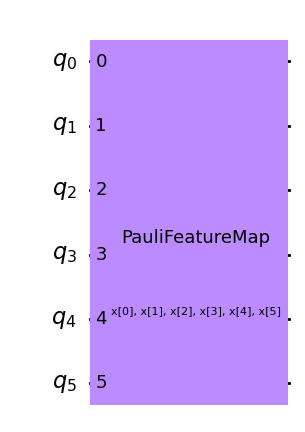

In [8]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit.visualization import circuit_drawer

# Define the parameter vector
training_params = ParameterVector("θ", 1)

# Define the quantum circuit with PauliFeatureMap
fm0 = QuantumCircuit(6)
for i in range(6):
    fm0.rx(training_params[0], i)

# Define the PauliFeatureMap


# Create the feature map, composed of the two circuits
# fm = fm0.compose(fm1)
fm=PauliFeatureMap(6, entanglement='linear')
# Print the circuit and trainable parameters
print(circuit_drawer(fm, output='mpl'))
print(f"Trainable parameters: {training_params}")
fm.draw(output="mpl")


In [9]:
print(transpile(fm,optimization_level=3).depth())

25


In [10]:
# Connecting with IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
# Loading your IBM Quantum account(s)
QiskitRuntimeService.save_account(channel="ibm_quantum", token="f0fac8f6a1cfa96fd78d6dcb9480ce59126296fa6e16e54511920a1b23e3ffaaa958a49dd9d11b7ab3a53b5c370286073f27cfc98b180fda299efe1e1dbadacf",overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum")

In [11]:
print(service.backends())

[<IBMBackend('ibmq_belem')>, <IBMBackend('simulator_mps')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_quito')>, <IBMBackend('ibmq_lima')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_perth')>]


In [12]:
from qiskit.providers.aer.noise import NoiseModel


# Get a real backend
real_backend = service.get_backend('ibm_perth')
# Create a noise model from the real backend
noise_model = NoiseModel.from_backend(real_backend)
print(noise_model)



NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'cx', 'reset', 'x', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (3, 5)), ('cx', (5, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (4, 5)), ('cx', (5, 4)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,))]


In [15]:
# Use the IBM quantum backend
backend = service.backend("ibmq_qasm_simulator")


In [16]:
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
# backend = QasmSimulator(noise_model=noise_model)
with Session(service=service, backend=backend):
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(Xtrain, ytrain)

Fit and Test the Model

In [ ]:
# # Use QSVC for classification
# qsvc = QSVC(quantum_kernel=optimized_kernel)

# # Fit the QSVC
# qsvc.fit(Xtrain, ytrain)

In [ ]:


# Predict the labels
labels_test = qsvc.predict(Xtest)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=ytest, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest,labels_test))
print(classification_report(ytest,labels_test))

Visualize the Kernel Training Process

In [ ]:
# plot_data = cb_qkt.get_callback_data()  # callback data
# K = optimized_kernel.evaluate(Xtrain)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
# fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
# ax[0].set_xlabel("Iterations")
# ax[0].set_ylabel("Loss")
# ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
# fig.tight_layout()
# plt.show()